# StyleAligned: Zero-Shot Style Alignment among a Series of Generated Images via Attention Sharing

### **Authors**: ***Borgi Alessio***, ***Danese Francesco***

### **Abstract**
In this notebook we aim to reproduce and enhance **[StyleAligned](https://arxiv.org/abs/2312.02133)**, a novel technique introduced by **Google Research**, for achieving **Style Consistency** in large-scale Text-to-Image (T2I) generative models. While current T2I models excel in creating visually compelling images from textual descriptions, they often struggle to maintain a consistent style across multiple images generated. Traditional methods to address this require extensive fine-tuning and manual intervention.

**StyleAligned** addresses this challenge by introducing minimal **Attention Sharing** during the **Diffusion Process**, ensuring **Style Alignment among generated images** without the need for optimization or fine-tuning (**Zero-Shoot Inference**). The method operates by leveraging a straightforward inversion operation to apply a reference style across various generated images, maintaining high-quality synthesis and fidelity to the provided text prompts.

### 0: SETTINGS & IMPORTS

#### 0.1: CLONE REPOSITORY AND GIT SETUP

In the following cell, we setup the code, by cloning the repository, setting up the Git configurations, and providing some other useful commands useful for git.  

In [ ]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAlignedDiffModels.git

# Change directory to the cloned repository
%cd StyleAlignedDiffModels
%ls

# Set up Git configuration
!git config --global user.name "Alessio Borgi"
!git config --global user.email "alessioborgi3@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 124 (delta 66), reused 50 (delta 19), pack-reused 0
Receiving objects: 100% (124/124), 16.40 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/StyleAlignedDiffModels
imgs/         README.md         src/                            Style_Aligned_Transfer_SDXL.ipynb
inversion.py  requirements.txt  StyleAligned_Explanation.ipynb  TO-DO.txt
LICENSE       sa_handler.py     Style_Aligned_SDXL_old.ipynb


#### 0.2: INSTALL AND IMPORT REQUIRED LIBRARIES

We proceed then by installing and importing the required libraries.

In [ ]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

In [ ]:
import torch
import einops
import mediapy
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from typing import Callable
from dataclasses import dataclass
from __future__ import annotations
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers import StableDiffusionXLPipeline, DDIMScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### 1: UTILS IMPLEMENTATION

#### 1.1: ADAIN MODULE

The **[Adaptive Instance Normalization (AdaIN)](https://arxiv.org/abs/1703.06868)** module is essential for **StyleAligned**. This works by first computing the mean and standard deviation of the input feature tensor $x$, independently for each feature map. The mean $\mu_x$ and standard deviation $\sigma_x$ are calculated as: $$\mu_x = \frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} x_{ij}$$ and $$\sigma_x = \sqrt{\frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} (x_{ij} - \mu_x)^2 + \epsilon}$$ where $H$ and $W$ are the height and width of the feature map, respectively, and $\epsilon$ is a small constant for numerical stability. These statistics are then matched to those of the style features $y$ by normalizing the input features $x$ and then scaling and shifting them using the style's mean $\mu_y$ and standard deviation $\sigma_y$.

The transformed feature tensor is given by: $$\text{AdaIN}(x, y) = \sigma_y \left( \frac{x - \mu_x}{\sigma_x} \right) + \mu_y$$

AdaIN receives a content input $x$ and a style input $y$, and simply aligns the channel wise mean and variance of $x$ to match those of $y$.
This process enables the content to adopt the style's statistical properties, facilitating effective style transfer, adding almost no computational cost.

In the StyleAligned project, instead of applying this normalization on convolutional-extracted feature maps, we embed it in the self attention layer: the AdaIN module is utilized to normalize the Queries $Q_t$ and Keys $K_t$ of the target image using the Queries $Q_r$ and Keys $K_r$ of the reference image:

$$\hat Q_t = \text{AdaIN}(Q_t, Q_r) \;\;\;\;\;\;\;\;\;\;\;\;\;\; \hat K_t = \text{AdaIN}(K_t, K_r)$$

For the images in the first half of the batch, the reference image is the first one in the batch; for the second half of the batch the reference is the image in the middle of the entire batch (index = batchsize//2). Note that the middle image is dependent on the first one, therefore the same style is transmitted throughout the whole batch, while slightly increasing diversity.

**Appendix:**

How are Queries, Keys and Values constructed if the previous layer is a convolutional layer? Suppose the convolution resulted in a feature map of size (batch, channels, height, width); then each "pixel" is considered a token with its channels as dimensions/features of the token, resulting in *height $×$ width* tokens, ready to be projected into Q, K and V via learnable linear layers. (See image below)

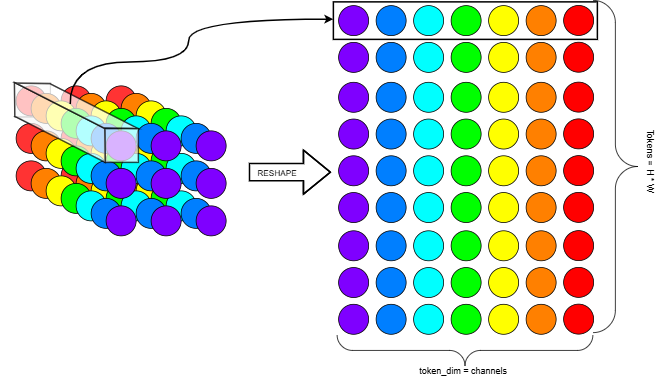

In [ ]:
#@title Ignore
'''
feat = torch.randn(16, 10, 1, 32)
b = feat.shape[0]
feat_style = torch.stack((feat[0], feat[b // 2])).unsqueeze(1)
print(feat_style.shape)
feat_style = feat_style.expand(2, b // 2, *feat.shape[1:])
print(feat_style.shape)
feat_style.reshape(*feat.shape).shape
'''

torch.Size([2, 1, 10, 1, 32])
torch.Size([2, 8, 10, 1, 32])


torch.Size([16, 10, 1, 32])

In [ ]:
T = torch.tensor # Create Alias for torch.tensor to increase readability

def concat_first(feat: T, dim=2) -> T: # takes K or V as input with shape = (batch, heads, tokens, dim_head)
    feat_style = expand_first(feat) # creates K/V of the two reference imgs (1th and middle-batch) of shape -> as above
    # feat_style holds the K/V of the first image repeated for the first half of the batch,
    # and of the middle img repeated for the second half of the batch
    return torch.cat((feat, feat_style), dim=dim) # concatenate the real K/V along the "tokens" dimensions, so that Q_target pays attention to both target and reference(s) Keys and Values tokens

# when this takes mean and std -> input shape: (batch, heads, 1, channels), see below
# when it takes K or V -> input shape: (batch, heads, tokens, dim_head), as used in "concat_first" above
def expand_first(feat: T) -> T:
    b = feat.shape[0] # Extract batch size
    feat_style = torch.stack((feat[0], feat[b // 2])).unsqueeze(1) # shape: (2, 1, heads, 1, channels), stack the mean (or std) of first and middle images in the batch
    feat_style = feat_style.expand(2, b // 2, *feat.shape[1:]) # repeat the mean or std batch/2 times (since we are considering 2 stats, from first and middle img in the batch)
    return feat_style.reshape(*feat.shape) # reshape so that first half of batch has assigned the mean/std of the first img, second half of the middle image

def calc_mean_std(feat, eps: float = 1e-5) -> tuple[T, T]:  # computes mean and std along number of tokens dimension
    feat_std = (feat.var(dim=-2, keepdims=True) + eps).sqrt()
    feat_mean = feat.mean(dim=-2, keepdims=True)
    return feat_mean, feat_std # output shape: (batch, heads, 1, channels)

def adain(feat: T) -> T: # Input shape: (Batch, Heads, #Tokens, Channels), #Tokens is number of "pixels" in the feature map, channels = dim_head = token_dim
    feat_mean, feat_std = calc_mean_std(feat)
    feat_style_mean = expand_first(feat_mean)
    feat_style_std = expand_first(feat_std)
    feat = (feat - feat_mean) / feat_std  # normalize the feature map
    feat = feat * feat_style_std + feat_style_mean  # scale and shift the feature map (reparameterization with reference stats)
    return feat


In [ ]:
attn = attention_processor.Attention(query_dim=32, dim_head = 64, heads = 8)
# both Q and K and V are projected from the input hidden states to a dimension that matches heads * dim_head.
# example: Projected from (Batch, tokens, 32) to (Batch, tokens, 512), and then reshaped to (Batch, tokens, 8 = heads, 64).
attn

Attention(
  (to_q): Linear(in_features=32, out_features=512, bias=False)
  (to_k): Linear(in_features=32, out_features=512, bias=False)
  (to_v): Linear(in_features=32, out_features=512, bias=False)
  (to_out): ModuleList(
    (0): Linear(in_features=512, out_features=32, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
class DefaultAttentionProcessor(nn.Module):

    def __init__(self):
        super().__init__()
        self.processor = attention_processor.AttnProcessor2_0() # from diffusers.models import attention_processor

    def __call__(self, attn: attention_processor.Attention, hidden_states, encoder_hidden_states=None,
                 attention_mask=None, **kwargs):
        return self.processor(attn, hidden_states, encoder_hidden_states, attention_mask)

class SharedAttentionProcessor(DefaultAttentionProcessor):

    def shared_call(
            self,
            attn: attention_processor.Attention,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None,
            **kwargs
    ):

        residual = hidden_states
        input_ndim = hidden_states.ndim
        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states) # linear layer "channels" -> "heads * dim_heads"
        key = attn.to_k(hidden_states) # same as above
        value = attn.to_v(hidden_states) # same as above
        inner_dim = key.shape[-1] # get "heads * dim_heads" value
        head_dim = inner_dim // attn.heads # infer "dim_head" by dividing for the number of heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) # shape all back to (batch, heads, tokens, dim_head)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) # same as above
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) # same as above
        # if self.step >= self.start_inject:
        # Adaptive Normalization of Q and K (and eventually V)
        if self.adain_queries:
            query = adain(query)
        if self.adain_keys:
            key = adain(key)
        if self.adain_values: # usually false
            value = adain(value)
        # shared attention layer
        # Q, V and K shape = (batch, heads, tokens, dim_head)
        if self.share_attention:
            key = concat_first(key, -2) # create Keys = [K_t, K_r] -> shape: (batch, heads, 2*tokens, dim_head)
            value = concat_first(value, -2) # create Values = [V_t, V_r] -> shape: (batch, heads, 2*tokens, dim_head)
            hidden_states = nnf.scaled_dot_product_attention(
                query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
            ) # hidden_states output shape -> (batch, heads, tokens, dim_head) since Q not double (.,.,tokens,.) and att = softmax(Q * K'/sqrt(dim_head)) * V
        else:
            hidden_states = nnf.scaled_dot_product_attention(
                query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
            )

        # now heads concatenation for later re-projection as in standard Multi Head Attention
        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim) # transpose -> (b, t, h, d_h); reshape -> (b, t, h*d_h)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states) # to_out[0] = Linear(in_features = heads * dim_heads, out_features = dim_heads, bias=True)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)
        # hidden_states shape -> (batch, tokens, dim_head) = (batch, pixels, channels)
        if input_ndim == 4:
            # shape it back to a "feature_maps" ready for convolution
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width) # transpose -> (b, c, pixels); reshape to create an "image" -> (b, c, h, w)

        if attn.residual_connection:
            hidden_states = hidden_states + residual # residuals were initial input hidden_states untouched, before attention mechanismf

        hidden_states = hidden_states / attn.rescale_output_factor
        return hidden_states

    def __call__(self, attn: attention_processor.Attention, hidden_states, encoder_hidden_states=None,
                 attention_mask=None, **kwargs):

        hidden_states = self.shared_call(attn, hidden_states, hidden_states, attention_mask, **kwargs)

        return hidden_states

    def __init__(self, style_aligned_args: StyleAlignedArgs):
        super().__init__()
        self.share_attention = style_aligned_args.share_attention
        self.adain_queries = style_aligned_args.adain_queries
        self.adain_keys = style_aligned_args.adain_keys
        self.adain_values = style_aligned_args.adain_values
        self.shared_score_scale = style_aligned_args.shared_score_scale
        self.shared_score_shift = style_aligned_args.shared_score_shift

In [ ]:
from dataclasses import dataclass

@dataclass(frozen=True)
class StyleAlignedArgs:
    share_group_norm: bool = True
    """
    Indicates whether to share group normalization across the model.
    """

    share_layer_norm: bool = True
    """
    Indicates whether to share layer normalization across the model.
    """

    share_attention: bool = True
    """
    Indicates whether to share attention mechanisms across the model.
    """

    adain_queries: bool = True
    """
    Indicates whether to apply AdaIN (Adaptive Instance Normalization) to the queries.
    """

    adain_keys: bool = True
    """
    Indicates whether to apply AdaIN to the keys.
    """

    adain_values: bool = False
    """
    Indicates whether to apply AdaIN to the values.
    """

    only_self_level: float = 0.0
    """
    Level of self-attention to be applied exclusively.
    """

### 4: DDIM \& PIPELINE DEFINITION
We then proceed to load the **SDXL (Stable Diffusion XL)** Model and configure the **DDIM (Denoising Diffusion Implicit Models) Scheduler**. We then configure the **Pipeline**.

#### 4.1: DDIM SCHEDULER

The **DDIM Scheduler** is the component used in diffusion models for generating high-quality samples from noise. It controls the denoising process by defining a schedule for adding and removing noise to and from the data. The scheduler is essential in determining how the model transitions from pure noise to a final, coherent image or other data form.

In particular, its parameters are:
- **beta_start (float)**: Starting value of beta, the variance of the noise schedule.
- **beta_end (float)**: Ending value of beta, the variance of the noise schedule.
- **beta_schedule (str)**: The type of schedule for beta. (Possible values: "linear", "scaled_linear", "squaredcos_cap_v2", "sigmoid").
- **clip_sample (bool)**: If True, the samples are clipped to [-1, 1].
- **set_alpha_to_one (bool)**: If True, alpha will be set to 1 at the end of the sampling process.
- **num_train_timesteps (int)**: The number of diffusion steps used during training.
- **timestep_spacing (str)**: The method to space out timesteps.(Possible values: "linspace", "leading").
- **prediction_type (str)**: The type of prediction model used in the scheduler. (Possible values: "epsilon", "sample", "v-prediction").
- **trained_betas (torch.Tensor or None)**: Optional tensor of pre-trained betas to use in the scheduler.

##### 4.1.1: DIFFUSION PROCESS

The diffusion process involves adding noise to the data over a series of timesteps, which is described by the forward process:

$$ q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{\alpha_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}) $$

where:
- $\alpha_t$ and $\beta_t$ are the scaling and noise variance terms, respectively.

##### 4.1.2: REVERSE PROCESS

The reverse process aims to recover the data by denoising it, and is given by:

$$ p_{\theta}(\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_{\theta}(\mathbf{x}_t, t), \sigma_t^2 \mathbf{I}) $$

where:
- $\mu_{\theta}(\mathbf{x}_t, t)$ is the predicted mean.
- $\sigma_t$ is the standard deviation of the noise at timestep $t$.

##### 4.1.3: BETA SCHEDULE

The beta values are scheduled over timesteps from `beta_start` to `beta_end`. The schedule can be:
- **Linear**:

$$ \beta_t = \beta_{\text{start}} + t \frac{\beta_{\text{end}} - \beta_{\text{start}}}{T} $$

- **Scaled Linear**:

$$ \beta_t = \beta_{\text{start}} + t \left(\frac{\beta_{\text{end}} - \beta_{\text{start}}}{T}\right)^2 $$

- **Sigmoid**:

$$ \beta_t = \beta_{\text{start}} + (\beta_{\text{end}} - \beta_{\text{start}}) \cdot \text{sigmoid}(t) $$

- **Squared Cosine (squaredcos\_cap\_v2)**:

$$ \beta_t = \beta_{\text{start}} + 0.5 \left(1 - \cos\left(\frac{t \pi}{T}\right)\right) (\beta_{\text{end}} - \beta_{\text{start}}) $$

##### 4.1.4: INFERENCE WITH DDIM

During inference, the denoising process can be described as:

$$ \mathbf{x}_{t-1} = \sqrt{\alpha_{t-1}} \left( \frac{\mathbf{x}_t - \sqrt{1 - \alpha_t} \mathbf{\epsilon}_{\theta}(\mathbf{x}_t, t)}{\sqrt{\alpha_t}} \right) + \sqrt{1 - \alpha_{t-1} - \sigma_t^2} \mathbf{\epsilon}_{\theta}(\mathbf{x}_t, t) $$

where:
- $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t, t)$ is the noise predicted by the model.
- $\sigma_t$ is the standard deviation for the timestep $t$.

In [ ]:
scheduler_linear = DDIMScheduler(
    beta_start=0.00085,                 # Starting value of beta
    beta_end=0.012,                     # Ending value of beta
    beta_schedule="scaled_linear",      # Type of schedule for beta values
    clip_sample=False,                  # Whether to clip samples to a specified range
    set_alpha_to_one=False,             # Whether to set alpha to one at the end of the process

    num_train_timesteps=1000,           # Number of diffusion steps used during training
    timestep_spacing="linspace",        # Method to space out timesteps
    prediction_type="epsilon",          # Type of prediction model used in the scheduler
    trained_betas=None                  # Optional pre-trained beta values
)

scheduler = scheduler_linear

### 4.2: SDXL PIPELINE DEFINITION

We then proceed to **load** the **pre-trained `StableDiffusionXLPipeline` model** with specific configurations to optimize for GPU memory usage and ensure efficient processing. Below is a breakdown of each parameter and its purpose:

- **pretrained_model_name_or_path**: The name or path of the pre-trained model to be loaded. In this example, we use `"stabilityai/stable-diffusion-xl-base-1.0"`, which is a pre-trained model available in the Stability AI repository.
- **torch_dtype**: Specifies the data type for the model's tensors. Here, `torch.float16` is used to enable mixed precision, which helps reduce memory usage and improve computation speed.
- **variant**: Indicates the model variant. `"fp16"` is used to specify 16-bit floating point precision, aligning with the `torch_dtype` parameter.
- **use_safetensors**: Determines whether to use the `safetensors` library for safe tensor loading. Setting this to `True` ensures safer model loading.
- **scheduler**: An instance of the scheduler to be used for the diffusion process. In this example, we use a `DDIMScheduler` instance configured for efficient sampling.
- **revision**: Specifies the model version to use. The default value is `None`, which means the latest version will be used.
- **use_auth_token**: The authentication token used for accessing private models. The default value is `None`, meaning no authentication is required.
- **cache_dir**: The directory where the downloaded model will be cached. The default value is `None`, which uses the default cache directory.
- **force_download**: Forces the model to be downloaded even if it exists locally. The default value is `False`.
- **resume_download**: Resumes a partial download if available. The default value is `False`.
- **proxies**: A dictionary of proxy servers to use. The default value is `None`, meaning no proxies are used.
- **local_files_only**: Uses only local files if set to `True`. The default value is `False`.
- **device_map**: Specifies device placement for model layers. The default value is `None`, which uses the default placement.
- **max_memory**: Specifies the maximum memory allowed for each device. The default value is `None`, meaning no specific memory limit is set.

Finally, the model is moved to the GPU for faster computations using `.to("cuda")`.

The use of mixed precision (`torch_dtype=torch.float16` and `variant="fp16"`) helps in reducing memory usage and improving performance. This configuration is particularly useful when working with large models and limited GPU memory.

In [ ]:
SDXL_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0",  # The model name or path
    torch_dtype=torch.float16,            # Data type for the model's tensors
    variant="fp16",                       # Model variant for 16-bit floating point precision (Mixed Precision)
    use_safetensors=True,                 # Use the safetensors library for safe tensor loading
    scheduler=scheduler,                  # Scheduler instance for the diffusion process

    revision=None,                        # Model version to use, default is None
    use_auth_token=None,                  # Authentication token, None means no authentication
    cache_dir=None,                       # Directory to cache the downloaded model, None uses default
    force_download=False,                 # Force download even if the model exists locally
    resume_download=False,                # Resume a partial download if available
    proxies=None,                         # Dictionary of proxy servers to use, None means no proxies
    local_files_only=False,               # Use only local files if set to True
    device_map=None,                      # Device placement for model layers, None uses default placement
    max_memory=None                       # Maximum memory allowed for each device, None means no specific limit
).to("cuda")                              # Move the model to the GPU for faster computations

In [ ]:
handler = Handler(SDXL_Pipeline)
sa_args = StyleAlignedArgs(share_group_norm=False,
                                      share_layer_norm=False,
                                      share_attention=True,
                                      adain_queries=True,
                                      adain_keys=True,
                                      adain_values=False
                                     )

handler.register(sa_args)

### 5: RUNNING STYLE-ALIGNED with A SET OF PROMPTS WITHOUT REFERENCE IMAGE

TO RUN IF YOU HAVE ENOUGH GPU RAM

In [ ]:
# run StyleAligned

sets_of_prompts = [
  "a toy train. macro photo. 3d game asset",
  "a toy airplane. macro photo. 3d game asset",
  "a toy bicycle. macro photo. 3d game asset",
  "a toy car. macro photo. 3d game asset",
  "a toy boat. macro photo. 3d game asset",
]
images = SDXL_Pipeline(sets_of_prompts,).images
mediapy.show_images(images)

TO RUN IF YOU HAVEN'T ENOUGH GPU RAM

In [ ]:
# run StyleAligned
sets_of_prompts = [
  "a toy train. macro photo. 3d game asset",
  "a toy airplane. macro photo. 3d game asset",
  "a toy bicycle. macro photo. 3d game asset",
  "a toy car. macro photo. 3d game asset",
  "a toy boat. macro photo. 3d game asset",
]
# sets_of_prompts = [
#   "a hot hair balloon, simple wooden statue",
#   "a friendly robot, simple wooden statue",
#   "a bull, simple wooden statue",
# ]
images = []
for prompt in sets_of_prompts:
    # Generate image for each prompt individually
    image = SDXL_Pipeline([prompt]).images[0]
    images.append(image)
    # Clear CUDA cache to free memory
    torch.cuda.empty_cache()

    # Print Memory summary
    # print(torch.cuda.memory_summary(device=None, abbreviated=False))

mediapy.show_images(images)

### 6: STYLE-ALIGNED WITH REFERENCE IMAGE

In this section, we develop the **StyleAligned** method that **maintains visual coherence** w.r.t. a **Reference Style Image**.


#### 6.1: LOADING REFERENCE IMAGE & SETTING PARAMETERS

As first thing, we **load a Reference Image** from which you will "copy the style". Indeed, we will ask for the newly generated images to stick with the same style of the Reference image, i.e., to be **Style-Aligned**.
In particular, we will define 3 **Image Parameters** here:
- **reference_style**: This is the reference style describing the reference image.
- **reference_prompt**: This is the reference prompt describing the reference image.
- **reference_image_path**: This is the path to the reference image.

As second step, you will set the parameters relative to the **Diffusion Inversion Process**. This process in a.k.a as **Temperature Scaling**, that aims to inject confidence/randomness in a classification/generation model. In this case, we aim at injecting more styleAlignment or randomness to the image generated.

In particular, you will set the parameters relative to:
- **num_inference_steps**: The number of inference steps to be performed during the Diffusion Inversion Process.
- **guidance_scale**: Here we set the parameter to have **Guidance Scale**, a parameter used in **guided diffusion models** to control the influence of the conditioning signal (e.g., a text prompt) during the image generation process, with the purpose to balance the model’s adherence to the conditioning signal and its natural generative tendencies. In particular:
	- **High Guidance Scale (>1)**: Increases the influence of the conditioning signal, making the generated images more aligned with the prompt. The model is more likely to produce images with features that are explicitly described in the prompt, leading to more detailed and specific outputs. Very high values might cause the model to overfit to the prompt, potentially losing some naturalness or introducing artifacts.
	- **Default Guidance Scale (=1)**: A guidance scale of 1.0 means that the model’s predictions are equally balanced between the conditional and unconditional signals, providing a baseline level of adherence to the prompt.
	- **Low Guidance Scale (<1)**: A lower guidance scale reduces the effect of the guiding input, making the generated images less constrained by the prompt. The model has more freedom to generate diverse and potentially more creative outputs that are not strictly bound to the prompt. Very low values might cause the model to generate images that are too generic and not sufficiently aligned with the prompt.
- **style_alignment_score_shift**: This parameter is used to **shift** the **scores logarithmically**. In particular, we will have:
	- **High Values (>1)**: This will **increase** the **StyleAlignment**, making therefore the output image to be closer to the reference.
	- **Low Values (<=1)**: This will **decrease** the **StyleAlignment**, making therefore the output image to be farther to the reference.
- **style_alignment_score_scale**: This parameter is used to **scale** the scores or weights within the model. More in detail:
	- **High Values (>1)**: This increases the magnitude of the scores, making the model more confident and therefore not varying so much the generation process.
	- **Standard Value (=1)**: This translates in having no rescaling.
	- **Low Values (<1)**: This coincides to having more generalization (injecting randomness) into the generation process.

***Special Configuration for Famous Images***

For very famous images, it might be beneficial to suppress the **Shared Attention** to the reference image to avoid overfitting or excessive influence from the reference.

In [ ]:
# 1) Medieval Painting
# Set the source style, prompt and path.
reference_style = "medieval painting"
reference_prompt = f'Man laying in a bed, {reference_style}.'
reference_image_path = './imgs/medieval-bed.jpeg'

# 2) Cubism Painting
# reference_style = "cubism painting"
# reference_prompt = f'Two men smoking water pipe, {reference_style}.'
# reference_image_path = './imgs/Picasso_Smoking_Water_Pipe.jpeg'


# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 10.0

# 1) Normal Painting
# These are some parameters you can Adjust to Control StyleAlignment to Reference Image.
style_alignment_score_shift = 2  # higher value induces higher fidelity, set 0 for no shift
style_alignment_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# 2) Very Famous Paintings
# style_alignment_score_shift = 1
# style_alignment_score_scale = 0.5

In [ ]:
# Load the reference image and resize it to 1024x1024 pixels.
ref_image = np.array(load_image(reference_image_path).resize((1024, 1024)))

# Display the output image.
mediapy.show_image(ref_image, title="Reference Image for Style Alignment", height=256)

#### 6.2: FUNCTION FOR PROMPT TOKENIZATION & EMBEDDING

Hereafter, we aim to create the function that, taking a **text prompt** in **input**, **tokenizes** it through a Tokenizer, and then generates **embeddings** using a text encoder.

It will then return in output both the **Hidden State Embeddings** (contextual representations for each token from the second last layer of the text encoder) and the **Pooled Output Embeddings** (single vector representation capturing the overall meaning of the input text). If the prompt is empty, it returns zero tensors as negative embeddings.

In [ ]:
# Alias for torch.Tensor type
T = torch.Tensor

# Alias for a type that can be either a torch.Tensor or None
TN = T | None

# Defining a type alias for the Diffusion Inversion Process type of callable.
InversionCallback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

The function we will develop for this is going to receive as Parameters:
- ***prompt***: A string containing the text prompt to be tokenized and embedded.
- ***tokenizer***: An instance of a tokenizer, used to convert the text prompt into token IDs.
- ***text_encoder***: An instance of a text encoder, used to generate embeddings from the token IDs.
- ***device***: The device (e.g., CPU or GPU) to run the computations on.

The steps involved are:
- **1) Tokenize the Input Prompt**: Converts the input text (prompt) into a sequence of tokens, which are numerical representations (token IDs) that can be processed by the model.
- **2) Extract Token IDs**: Extracts the token IDs from the tokenized inputs.
- **3) Generate Embeddings**: Generates embeddings for the tokenized input using the text encoder.
- **4) Extract Pooled Output Embeddings**: Extracts the pooled output embeddings, summarizing the input sequence.
- **5) Extract Hidden State Embeddings**: Extracts the hidden state embeddings from the second last layer of the text encoder.
- **6) Handle Empty Prompt Case**: Checks if the input prompt is empty and handles this case.
- **7) Return Embeddings**: Returns the generated embeddings.

In [ ]:
def _get_text_embeddings(prompt: str, tokenizer, text_encoder, device):

    # 1) Tokenize the Input Prompt: Tokenize the input prompt using the provided tokenizer, with padding and truncation.
    text_inputs = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
    # 2) Extract Token IDs: Extract the input IDs (token indices) from the tokenized inputs.
    text_input_ids = text_inputs.input_ids

    # 3) Generate Embeddings: Use torch.no_grad() to disable gradient computation for the following operations.
    with torch.no_grad():
        # Generate embeddings for the tokenized input IDs using the text encoder.
        # The embeddings include output hidden states.
        prompt_embeds = text_encoder(
            text_input_ids.to(device),  # Move input IDs to the specified device (e.g., GPU).
            output_hidden_states=True,  # Request hidden states from the encoder.
        )

    # 4) Extract Pooled Output Embeddings: Extract the pooled output embeddings (first element of the tuple returned by the encoder).
    pooled_prompt_embeds = prompt_embeds[0]
    # 5) Extract Hidden State Embeddings: Extract the hidden state embeddings from the second last layer of the encoder.
    prompt_embeds = prompt_embeds.hidden_states[-2]

    # 6) Handle Empty Prompt Case: If the prompt is empty, return zero tensors as negative embeddings.
    if prompt == '':
        # Create a zero tensor with the same shape as the hidden state embeddings.
        negative_prompt_embeds = torch.zeros_like(prompt_embeds)
        # Create a zero tensor with the same shape as the pooled output embeddings.
        negative_pooled_prompt_embeds = torch.zeros_like(pooled_prompt_embeds)
        # Return the zero tensors for both negative embeddings and pooled negative embeddings.
        return negative_prompt_embeds, negative_pooled_prompt_embeds

    # 7) Returns the generated embeddings: Return the hidden state embeddings and the pooled output embeddings.
    return prompt_embeds, pooled_prompt_embeds

#### 6.4: TEXT EMBEDDING ENSEMBLE METHOD

In order to **enhance** the **model’s understanding** and **representation** of the **input text**, we proceed to generate and process text embeddings for a given prompt using **2 Different Text Tokenizers and Encoders**. We then prepares these embeddings and additional time IDs for conditioning within the StableDiffusionXLPipeline. We then return a dictionary containing the pooled embeddings and generated time IDs, as well as the concatenated text embeddings.

This choice has several advantages:
- Richness of Representation
- Combination of Different Models Strength
- Reducing Overfitting
- Enhancing Conditioning
- Improving Performance

In particular, the function receives the following **parameters**:
- ***model***: An instance of StableDiffusionXLPipeline.
- ***prompt***: A string containing the text prompt to be tokenized and embedded.

The steps involved are:
- **1) Get the Device**: Retrieve the device (e.g., CPU or GPU) on which the model is being executed.
- **2) Generate Text Embeddings**: Generate text embeddings using two different pairs of tokenizers and text encoders.
- **3) Concatenate Prompt Embeddings**: Concatenate the embeddings from the two sets of encoders along the last dimension.
- **4) Get Text Encoder Projection Dimension**: Retrieve the projection dimension from the configuration of the second text encoder.
- **5) Generate Additional Time IDs**: Generate additional time IDs required for conditioning.
- **6) Prepare Additional Condition Keyword Arguments**: Checks if the input prompt is empty and handles this case.
- **7) Return the Additional Condition Keyword Arguments and Concatenated Embeddings**: Return the prepared additional condition keyword arguments and concatenated prompt embeddings.


In [ ]:
def _encode_text_sdxl(model: StableDiffusionXLPipeline, prompt: str) -> tuple[dict[str, T], T]:

    # 1) Get the Device: Get the device (e.g., CPU or GPU) on which the model is being executed.
    device = model._execution_device

    # 2) Generate Text Embeddings:
    # Generate text embeddings using the first set of tokenizer and text encoder.
    prompt_embeds, pooled_prompt_embeds = _get_text_embeddings(prompt, model.tokenizer, model.text_encoder, device)

    # Generate text embeddings using the second set of tokenizer and text encoder.
    prompt_embeds_2, pooled_prompt_embeds2 = _get_text_embeddings(prompt, model.tokenizer_2, model.text_encoder_2, device)

    # 3) Concatenate Prompt Embeddings: Concatenate the embeddings from both sets of encoders along the last dimension.
    prompt_embeds = torch.cat((prompt_embeds, prompt_embeds_2), dim=-1)

    # 4) Get Text Encoder Projection Dimension: Retrieve the projection dimension from the configuration of the second text encoder
    text_encoder_projection_dim = model.text_encoder_2.config.projection_dim

    # 5) Generate Additional Time IDs: Generate additional time IDs required for conditioning.
    add_time_ids = model._get_add_time_ids((1024, 1024), (0, 0), (1024, 1024), torch.float16, text_encoder_projection_dim).to(device)

    # 6) Prepare Additional Condition Keyword Arguments: Prepare additional condition keyword arguments required for the model.
    added_cond_kwargs = {"text_embeds": pooled_prompt_embeds2, "time_ids": add_time_ids}

    # 7) Return the Additional Condition Keyword Arguments and Concatenated Embeddings:Return the prepared additional condition keyword arguments and concatenated prompt embeddings
    return added_cond_kwargs, prompt_embeds

#### 6.5: TEXT EMBEDDING: NEGATIVE CONDITIONING TECHNIQUE

We then proceed to **generate Text Embeddings** and **Conditioning Keywords** for both the **Given Prompt** and an **Empty Prompt** (used for **Negative Conditioning**). We concatenate these embeddings and keywords to create a combined representation that includes both positive and negative contexts.

These input prompts are used to guide the generation process in diffusion models (through **Guidance**) and improving the quality of generated outputs by considering **what the model should not generate (negative conditioning)**.

The **benefits** we get from this technique are:
- **Balanced Representation**
- **Improved Semantic Understanding**
- **Reduction of Noise**

In particular, the function receives the following **parameters**:
- ***model***: An instance of StableDiffusionXLPipeline.
- ***prompt***: A string containing the text prompt to be tokenized and embedded.

The steps involved are:
- **1) Encode Text with Given Prompt using Text Embedding Ensemble**: Generate text embeddings and conditioning keywords for the given text prompt.
- **2) Encode Text with Empty Prompt**: Generate text embeddings and conditioning keywords for an empty prompt (negative conditioning).
- **3) Concatenate Positive and Negative Embeddings**: Concatenate the embeddings from the negative and positive prompts.
- **4) Concatenate Positive and Negative Conditioning Keyword**: Concatenate the conditioning keywords from the negative and positive prompts.
- **5) Return Combined Conditioning Keywords and Embeddings**: Return the combined conditioning keywords and concatenated embeddings.

In [ ]:
def _encode_text_sdxl_with_negative(model: StableDiffusionXLPipeline, prompt: str) -> tuple[dict[str, T], T]:
    # 1) Encode Text with Given Prompt using Text Embedding EnsembleEncode Text with Given Prompt: Generate text embeddings and conditioning keywords for the given prompt.
    added_cond_kwargs, prompt_embeds = _encode_text_sdxl(model, prompt)

    # 2) Encode Text with Empty Prompt: Generate text embeddings and conditioning keywords for an empty prompt (negative conditioning).
    added_cond_kwargs_uncond, prompt_embeds_uncond = _encode_text_sdxl(model, "")

    # 3) Concatenate Positive and Negative Embeddings: Concatenate the embeddings from the negative and positive prompts.
    prompt_embeds = torch.cat((prompt_embeds_uncond, prompt_embeds))

    # 4) Concatenate Positive and Negative Conditioning Keywords: Concatenate the conditioning keywords from the negative and positive prompts.
    added_cond_kwargs = {
        "text_embeds": torch.cat((added_cond_kwargs_uncond["text_embeds"], added_cond_kwargs["text_embeds"])),
        "time_ids": torch.cat((added_cond_kwargs_uncond["time_ids"], added_cond_kwargs["time_ids"]))
    }

    # 5) Return Combined Conditioning Keywords and Embeddings: Return the combined conditioning keywords and concatenated embeddings.
    return added_cond_kwargs, prompt_embeds

#### 6.6: ENCODE THE REFERENCE IMAGE

We now switch our attention to the **Reference Image**. This is now processed and **encoded** using the **Variational Autoencoder (VAE)** of the **StableDiffusionXLPipeline**, and returns the resulting **latent representation**. The function handles the conversion of the image from a numpy array to a PyTorch tensor, normalizes it, encodes it using the VAE, and finally scales the latent representation.

The steps involved are:
- **1) Set VAE to Float32**: Ensure the VAE operates in float32 precision for encoding.
- **2) Convert Image to PyTorch Tensor**: Convert the input image from a numpy array to a PyTorch tensor and normalize pixel values to [0, 1].
- **3) Normalize and Prepare Image**: Scale pixel values to the range [-1, 1], rearrange dimensions, and add a batch dimension.
- **4) Encode Image Using VAE**: Use the VAE to encode the image into the latent space.
- **5) Reset VAE to Float16**: Optionally reset the VAE to float16 precision.
- **6) Return Latent Representation** : Return the encoded latent representation of the image.


In [ ]:
def _encode_image(model: StableDiffusionXLPipeline, image: np.ndarray) -> T:
    # 1) Set VAE to Float32: Ensure the VAE operates in float32 precision for encoding.
    model.vae.to(dtype=torch.float32)

    # 2) Convert Image to PyTorch Tensor: Convert the input image from a numpy array to a PyTorch tensor and normalize pixel values to [0, 1].
    image = torch.from_numpy(image).float() / 255.

    # 3) Normalize and Prepare Image: Scale pixel values to the range [-1, 1], rearrange dimensions, and add batch dimension.
    image = (image * 2 - 1).permute(2, 0, 1).unsqueeze(0)

    # 4) Encode Image Using VAE: Use the VAE to encode the image into the latent space.
    latent = model.vae.encode(image.to(model.vae.device))['latent_dist'].mean * model.vae.config.scaling_factor

    # 5) Reset VAE to Float16: Optionally reset the VAE to float16 precision.
    model.vae.to(dtype=torch.float16)

    # 6) Return Latent Representation: Return the encoded latent representation of the image.
    return latent

#### 6.7: SINGLE DENOISING STEP in DIFFUSION PROCESS

We now focus on performing a **Single Denoising Step** in the **Diffusion Process**. It calculates the next sample based on the current sample, the model output, and the current timestep. This function helps in progressing the denoising process step by step, gradually transforming the noisy sample back into the original image.

The steps involved are:
- **1) Calculate Current and Next Timesteps**: Compute the current and next timesteps for the denoising process.
- **2) Calculate Alpha Products**: Retrieve the alpha cumulative product for the current and next timesteps.
- **3) Calculate Beta Product**: Compute the beta cumulative product for the current timestep.
- **4) Compute Next Original Sample**: Calculate the next original sample using the current sample and model output.
- **5) Compute Next Sample Direction**: Determine the direction for the next sample.
- **6) Compute Next Sample**: Combine the next original sample and next sample direction to get the next sample.
- **7) Return Next Sample**: Return the computed next sample.

In [ ]:
def _next_step(model: StableDiffusionXLPipeline, model_output: T, timestep: int, sample: T) -> T:

    # 1) Calculate Current and Next Timesteps: Compute the current and next timesteps for the denoising process.
    timestep, next_timestep = min(timestep - model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps, 999), timestep

    # 2) Calculate Alpha Products: Retrieve the alpha cumulative product for the current and next timesteps.
    alpha_prod_t = model.scheduler.alphas_cumprod[int(timestep)] if timestep >= 0 else model.scheduler.final_alpha_cumprod
    alpha_prod_t_next = model.scheduler.alphas_cumprod[int(next_timestep)]

    # 3) Calculate Beta Product: Compute the beta cumulative product for the current timestep.
    beta_prod_t = 1 - alpha_prod_t

    # 4) Compute Next Original Sample: Calculate the next original sample using the current sample and model output.
    next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    # 5) Compute Next Sample Direction: Determine the direction for the next sample.
    next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output

    # 6) Compute Next Sample: Combine the next original sample and next sample direction to get the next sample.
    next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction

    # 7) Return Next Sample: Return the computed next sample.
    return next_sample

#### 6.8: GENERATE NOISE PREDICTIONS

We now focus on generating **Noise Predictions** for the **given Latent Representation** at a specific timestep. We use a **Guidance Scale** to **combine Unconditional and Conditional Noise Predictions**, which helps guide the model in generating outputs that are closer to the desired result.

The steps involved are:
- **1) Duplicate Latent Input**: Create a batch of two identical latent representations.
- **2) Generate Noise Predictions**: Use the model’s UNet to generate noise predictions for the duplicated latents.
- **3) Split Noise Predictions**: Split the noise predictions into unconditional and conditional components.
- **4) Apply Guidance**: Combine the unconditional and conditional noise predictions using the guidance scale.
- **5) Return Noise Prediction**: Return the combined noise prediction.

In [ ]:
def _get_noise_pred(model: StableDiffusionXLPipeline, latent: T, t: T, context: T, guidance_scale: float, added_cond_kwargs: dict[str, T]):
    # 1) Duplicate Latent Input: Create a batch of two identical latent representations.
    latents_input = torch.cat([latent] * 2)

    # 2) Generate Noise Predictions: Use the model's UNet to generate noise predictions for the duplicated latents.
    noise_pred = model.unet(latents_input, t, encoder_hidden_states=context, added_cond_kwargs=added_cond_kwargs)["sample"]

    # 3) Split Noise Predictions: Split the noise predictions into unconditional and conditional components.
    noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)

    # 4) Apply Guidance: Combine the unconditional and conditional noise predictions using the guidance scale.
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # 5) Return Noise Prediction: Return the combined noise prediction.
    return noise_pred

#### 6.9: DDIM (Denoising Diffusion Implicit Models) Denoising Process

We can now focus on the **DDIM (Denoising Diffusion Implicit Models) Denoising Process**. It iteratively refines the latent representation of an image starting from an initial noisy latent (z0), using noise predictions and timesteps to generate a sequence of progressively denoised latents. The function returns the sequence of latents from the denoising process.

The steps involved are:
- **1) Initialize Latent List**: Start with the initial latent representation (z0).
- **2) Encode Text with Negative Conditioning**: Generate text embeddings and conditioning keywords for the prompt, including also negative conditioning.
- **3) Prepare Latent for Inference**: Clone and detach the initial latent, and convert it to half precision.
- **4) Denoising Loop**: Perform the denoising process over the specified number of inference steps.
	- **4.1) Get Current Timestep**: Retrieve the current timestep.
	- **4.2) Generate Noise Prediction**: Use the model to predict noise for the current latent and timestep.
	- **4.3) Compute Next Latent**: Compute the next latent representation using the noise prediction.
	- **4.4) Append Latent to List**: Append the new latent to the list of all latents.
- **5) Return Sequence of Latents**: Concatenate all latents and reverse their order.

In [ ]:
def _ddim_loop(model: StableDiffusionXLPipeline, z0, prompt, guidance_scale) -> T:
    # 1) Initialize Latent List: Start with the initial latent representation.
    all_latent = [z0]

    # 2) Encode Text with Negative Conditioning: Generate text embeddings and conditioning keywords for the prompt, including also negative conditioning.
    added_cond_kwargs, text_embedding = _encode_text_sdxl_with_negative(model, prompt)

    # 3) Prepare Latent for Inference: Clone and detach the initial latent, and convert it to half precision.
    latent = z0.clone().detach().half()

    # 4) Denoising Loop: Perform the denoising process over the specified number of inference steps.
    for i in tqdm(range(model.scheduler.num_inference_steps)):
        # 4.1) Get Current Timestep: Retrieve the current timestep.
        t = model.scheduler.timesteps[len(model.scheduler.timesteps) - i - 1]

        # 4.2) Generate Noise Prediction: Use the model to predict noise for the current latent and timestep.
        noise_pred = _get_noise_pred(model, latent, t, text_embedding, guidance_scale, added_cond_kwargs)

        # 4.3) Compute Next Latent: Compute the next latent representation using the noise prediction.
        latent = _next_step(model, noise_pred, t, latent)

        # 4.4) Append Latent to List: Append the new latent to the list of all latents.
        all_latent.append(latent)

    # 5) Return Sequence of Latents: Concatenate all latents and reverse their order.
    return torch.cat(all_latent).flip(0)

#### 6.10:  UPDATE LATENT TENSORS CALLBACK

We focus now on creating a **Callback Function** that **updates the Latent Tensors** during the **Diffusion Process**. This callback is used to replace the current latent with a precomputed latent at each step, ensuring that the diffusion process follows a predefined path.

The steps involved are:
- **1) Define Callback Function**: Define a callback function to be called at the end of each diffusion step.
	- **1.1) Retrieve Current Latents**: Extract the current latents from the callback arguments.
	- **1.2) Update Latent**: Replace the first latent with a precomputed latent from the zts list.
	- **1.3) Return Updated Latents**: Return the updated latents.
- **2) Return Initial Latent and Callback**: Return the initial latent and the callback function.

In [ ]:
def make_inversion_callback(zts, offset: int = 0) -> [T, InversionCallback]:
    # 1) Define Callback Function: Define a callback function to be called at the end of each diffusion step.
    def callback_on_step_end(pipeline: StableDiffusionXLPipeline, i: int, t: T, callback_kwargs: dict[str, T]) -> dict[str, T]:
        # 1.1) Retrieve Current Latents: Extract the current latents from the callback arguments.
        latents = callback_kwargs['latents']

        # 1.2) Update Latent: Replace the first latent with a precomputed latent from the zts list.
        latents[0] = zts[max(offset + 1, i + 1)].to(latents.device, latents.dtype)

        # 1.3) Return Updated Latents: Return the updated latents.
        return {'latents': latents}

    # 2) Return Initial Latent and Callback: Return the initial latent and the callback function.
    return zts[offset], callback_on_step_end

#### 6.11: DDIM Inversion Process

We can now put all together and perform the the **DDIM (Denoising Diffusion Implicit Models) Inversion Process**. It starts by encoding the input image into a latent representation, sets the timesteps for the diffusion process, and then iteratively refines the latent representation using the DDIM loop. The final output is a sequence of latent representations.

The steps involved are:
- **1) Encode Image**: Encode the input image into a latent representation using the model’s VAE.
- **2) Set Timesteps**: Set the timesteps for the diffusion process.
- **3) Perform DDIM Loop**: Perform the DDIM denoising loop to generate a sequence of latent representations.
- **4) Return Sequence of Latents**: Return the sequence of latent representations generated by the DDIM loop.

In [ ]:
@torch.no_grad()
def ddim_inversion(model: StableDiffusionXLPipeline, x0: np.ndarray, prompt: str, num_inference_steps: int, guidance_scale: float) -> T:
    # 1) Encode Image: Encode the input image into a latent representation using the model's VAE.
    z0 = _encode_image(model, x0)

    # 2) Set Timesteps: Set the timesteps for the diffusion process.
    model.scheduler.set_timesteps(num_inference_steps, device=z0.device)

    # 3) Perform DDIM Loop: Perform the DDIM denoising loop to generate a sequence of latent representations.
    zs = _ddim_loop(model, z0, prompt, guidance_scale)

    # 4) Return Sequence of Latents: Return the sequence of latent representations generated by the DDIM loop.
    return zs

#### 7: DIFFUSION INVERSION PROCESS MAIN


In this section, we will undergo the **Diffusion Inversion Process** in order to **align the style of generated images with a reference style**. This process involves several key steps:


1. **Set Prompts**:
   - We define a set of prompts for generating images. The first prompt refers to the reference image, while the subsequent prompts are used to generate new images.
   - The reference style is appended to each of the subsequent prompts to ensure the generated images adhere to the desired style.

2. **Configure Style Alignment Handler**:
   - We initialize a handler for the Style Aligned (SA) model and configure it using the `StyleAlignedArgs` parameters. These parameters control various aspects of the style alignment process, such as normalization and attention mechanisms.

3. **Run Diffusion Inversion**:
   - We execute the DDIM inversion process to map the reference image to its latent representation. This inversion allows us to extract latent features that can be used to guide the generation of new images in the desired style.

4. **Generate Images**:
   - Using the latent representation obtained from the inversion process, we generate new images based on the defined prompts. We will generate random latent vectors of shape (number_of_prompts, 4, 128, 128) from a normal distribution. We will make use of generator to ensure that the random values are reproducible. In this step, I will have also to ensure that the latent vectors have the same data type as required by the model’s UNet.
   After this, we will set the first latent vector to the one extracted from the reference image, ensuring that the first generated image closely adheres to the reference style.
   The latent features of the reference image are combined with the prompts to produce images that are stylistically aligned with the reference image.

5. **Display Results**:
   - Finally, we display the generated images to visualize the effect of the style alignment.

This process demonstrates how to leverage the power of diffusion models and inversion techniques to generate images with consistent and coherent styles, guided by a reference image.

In [ ]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    reference_prompt,
    "A man working on a laptop",
    "A man eats pizza",
    "A woman playig on saxophone",
]

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {reference_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(SDXL_Pipeline)
sa_args = StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    style_alignment_score_shift=np.log(style_alignment_score_shift),
    style_alignment_score_scale=style_alignment_score_scale)
handler.register(sa_args)

In [ ]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = ddim_inversion(SDXL_Pipeline, ref_image, reference_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = make_inversion_callback(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(31)

# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,            # Random Latent Vectors shape
                      device='cpu',                         # Latent Vectors on CPU.
                      generator=rand_gen,                   # Random Number Generator.
                      dtype=SDXL_Pipeline.unet.dtype,).to('cuda:0') # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = SDXL_Pipeline(
    prompts,                                 # Prompts to generate images for.
    latents=latents,                         # Latent Vectors to guide the generation of images.
    callback_on_step_end=inversion_callback, # Callback to update the latent vectors during the generation process.
    num_inference_steps=num_inference_steps, # Number of Inference Steps to generate the images.
    guidance_scale=guidance_scale).images              # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(reference_style) + 3)] for p in prompts])